Phase 01

1.1 Initial Data Inspection

In [13]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:

import pandas as pd

# Load the dataset
df = pd.read_csv('../data/hotel_bookings.csv')

# Shape of the dataset
print("Shape:", df.shape)

# Data types
print("\nData Types:\n", df.dtypes)

# First and last 5 rows
print("\nFirst 5 rows:\n", df.head())
print("\nLast 5 rows:\n", df.tail())

# Summary statistics
print("\nSummary Statistics:\n", df.describe(include='all'))


Shape: (119390, 32)

Data Types:
 hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object


1.2 Missing Value Analysis

          Missing Values    Percent
company           112593  94.306893
agent              16340  13.686238
country              488   0.408744
children               4   0.003350


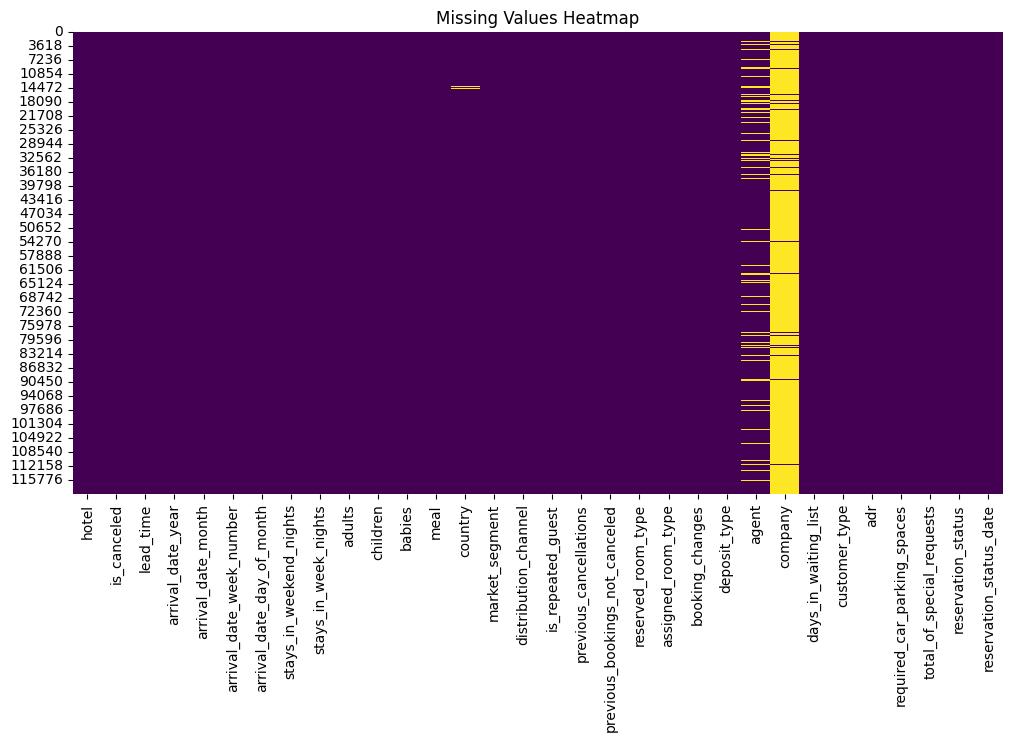

In [15]:


import seaborn as sns
import matplotlib.pyplot as plt

# Total and % missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)
print(missing_df)

# Heatmap of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


1.3 Data Quality Assessment

Number of duplicate rows: 31994


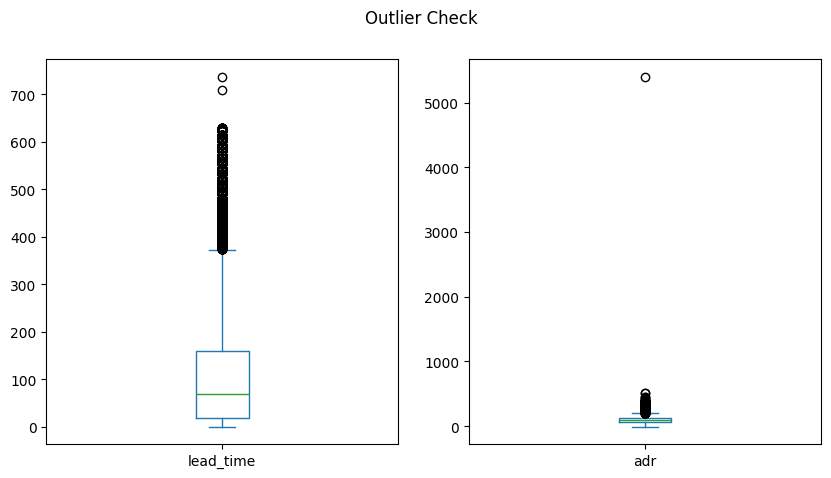

Records with 0 guests: 180


In [16]:
# Check for duplicates
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Quick outlier check (boxplot)
import matplotlib.pyplot as plt
df[['lead_time', 'adr']].plot(kind='box', subplots=True, layout=(1,2), figsize=(10,5))
plt.suptitle("Outlier Check")
plt.show()

# Check for total guests = 0 (illogical)
df['total_guests'] = df['adults'] + df['children'] + df['babies']
zero_guests = df[df['total_guests'] == 0]
print(f"Records with 0 guests: {zero_guests.shape[0]}")


Phase 02

2.1 Handling Missing Values

In [17]:
# Fill missing children values with 0
df['children'].fillna(0, inplace=True)

# Fill missing country with mode
country_mode = df['country'].mode()[0]
df['country'].fillna(country_mode, inplace=True)  # or df['country'].fillna('Unknown')

# Fill missing agent/company with 0
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)

# Ensure they are correct types (agent and company might be float)
df['agent'] = df['agent'].astype(int)
df['company'] = df['company'].astype(int)
df['children'] = df['children'].astype(int)


C:\Users\This PC\AppData\Local\Temp\ipykernel_1432\2828193539.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)
C:\Users\This PC\AppData\Local\Temp\ipykernel_1432\2828193539.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

2.2 Duplicate Detection and Removal

In [18]:
# Check for duplicates
duplicate_rows = df[df.duplicated()]
print(f"Duplicate rows: {duplicate_rows.shape[0]}")

# Drop duplicates
df = df.drop_duplicates()
print(f"New shape after removing duplicates: {df.shape}")


Duplicate rows: 32013
New shape after removing duplicates: (87377, 33)


2.3 Outlier Detection and Treatment

In [19]:
# Example: IQR for lead_time
Q1 = df['lead_time'].quantile(0.25)
Q3 = df['lead_time'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
outliers = df[(df['lead_time'] < (Q1 - 1.5 * IQR)) | (df['lead_time'] > (Q3 + 1.5 * IQR))]
print(f"Outliers in lead_time: {outliers.shape[0]}")

# Option: Remove them
df = df[~df.index.isin(outliers.index)]


Outliers in lead_time: 2396


2.4 Fix Data Inconsistencies

In [20]:
# Remove rows with total guests = 0
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df = df[df['total_guests'] > 0]

# Optional: convert dates to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])


Phase 03

3.1 Data Integrity Checks

In [21]:
# 1. Guests > 0 (already filtered in Phase 2, but recheck)
df['total_guests'] = df['adults'] + df['children'] + df['babies']
assert df['total_guests'].min() > 0, "Found records with 0 guests!"

# 2. Arrival dates valid
print(df['arrival_date_year'].unique())  # Should be 2015, 2016, 2017
print(df['arrival_date_month'].unique())  # Should be valid month names

# 3. Numerical ranges
print(df[['lead_time', 'adr', 'stays_in_week_nights', 'babies']].describe())

# 4. Check categories
print(df['meal'].unique())  # Should be only known meal types
print(df['market_segment'].unique())  # Should be consistent


[2015 2016 2017]
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
          lead_time           adr  stays_in_week_nights        babies
count  84817.000000  84817.000000          84817.000000  84817.000000
mean      72.316741    106.864518              2.592605      0.010882
std       73.361504     55.109413              2.014885      0.114036
min        0.000000     -6.380000              0.000000      0.000000
25%       11.000000     72.250000              1.000000      0.000000
50%       46.000000     99.000000              2.000000      0.000000
75%      117.000000    135.000000              3.000000      0.000000
max      296.000000   5400.000000             50.000000     10.000000
['BB' 'FB' 'HB' 'SC' 'Undefined']
['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']


3.3 Final Dataset Preparation

In [22]:
# Save cleaned dataset
df.to_csv('hotel_bookings_cleaned.csv', index=False)


Advanced Extensions

1. Feature Engineering

In [23]:
# Create total nights stayed
df['total_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Create total guests
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# Create booking month as number
import calendar
df['arrival_month_num'] = df['arrival_date_month'].apply(lambda x: list(calendar.month_name).index(x))

# High season flag (assume July, August as high season)
df['is_high_season'] = df['arrival_date_month'].isin(['July', 'August'])

# Weekday or weekend arrival
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_month_num'].astype(str) + '-' +
    df['arrival_date_day_of_month'].astype(str)
)
df['arrival_day_of_week'] = df['arrival_date'].dt.day_name()



 2. Automated Cleaning Pipeline

In [24]:
def clean_hotel_data(df):
    # Handle missing values
    df['children'].fillna(0, inplace=True)
    df['agent'].fillna(0, inplace=True)
    df['company'].fillna(0, inplace=True)
    df['country'].fillna(df['country'].mode()[0], inplace=True)

    # Convert types
    df['agent'] = df['agent'].astype(int)
    df['company'] = df['company'].astype(int)
    df['children'] = df['children'].astype(int)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Remove rows with 0 total guests
    df['total_guests'] = df['adults'] + df['children'] + df['babies']
    df = df[df['total_guests'] > 0]

    # Convert reservation date
    df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

    return df


In [30]:
df_original = pd.read_csv('../data/hotel_bookings.csv')
df_cleaned = pd.read_csv('hotel_bookings_cleaned.csv')


Quality Metrics & Dashboards

Example metrics

In [31]:
def quality_metrics(df_original, df_cleaned):
    print("Original shape:", df_original.shape)
    print("Cleaned shape:", df_cleaned.shape)
    print("Duplicates removed:", df_original.duplicated().sum())
    print("Missing values (original):")
    print(df_original.isnull().sum()[df_original.isnull().sum() > 0])
    print("Missing values (cleaned):")
    print(df_cleaned.isnull().sum().sum())  # should be 0


Visual (optional)

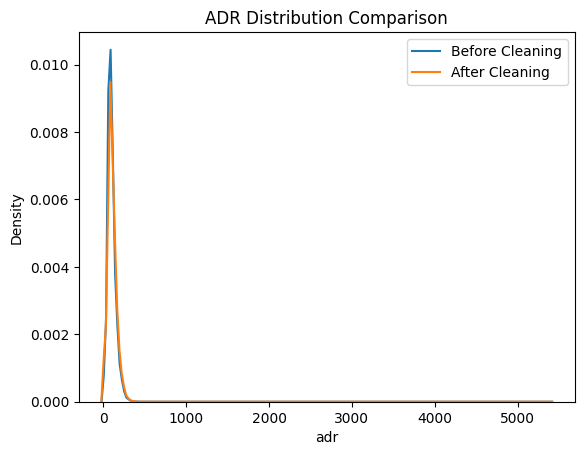

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# ADR distribution before and after
sns.kdeplot(df_original['adr'], label='Before Cleaning')
sns.kdeplot(df_cleaned['adr'], label='After Cleaning')
plt.title("ADR Distribution Comparison")
plt.legend()
plt.show()
